<a href="https://colab.research.google.com/github/VittorioBartolomeoSecondin/DVISProject-CAValli_Team/blob/main/Preprocessing_story2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and connecting to Google Drive

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import csv
import requests
import os
import zipfile
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preliminary actions

In [2]:
all_files = glob.glob("/content/drive/MyDrive/DV_project/story2/*")
all_files.sort()
print(all_files)

['/content/drive/MyDrive/DV_project/story2/disability.csv', '/content/drive/MyDrive/DV_project/story2/early_leavers_by_sex_labour.xlsx', '/content/drive/MyDrive/DV_project/story2/enrolment_by_age.csv', '/content/drive/MyDrive/DV_project/story2/pop_edu_sex_age_absolute.xlsx', '/content/drive/MyDrive/DV_project/story2/poverty_exclusion_risk.xlsx', '/content/drive/MyDrive/DV_project/story2/risk_2003_2020.xlsx', '/content/drive/MyDrive/DV_project/story2/risk_education.xlsx', '/content/drive/MyDrive/DV_project/story2/risk_labour.xlsx', '/content/drive/MyDrive/DV_project/story2/risk_sex_age.xlsx']


## Dictionaries: country --> abbreviation (and viceversa)

We create 2 dictionaries linking each country to its short abbreviation (*country_abbreviations*) and viceversa (*country_abbreviations_reversed*).

In [3]:
country_abbreviations = {
    'European Union - 27 countries (from 2020)': 'EU',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Czechia': 'CZE',
    'Denmark': 'DNK',
    'Germany': 'DEU',
    'Estonia': 'EST',
    'Ireland': 'IRL',
    'Greece': 'GRC',
    'Spain': 'ESP',
    'France': 'FRA',
    'Croatia': 'HRV',
    'Italy': 'ITA',
    'Cyprus': 'CYP',
    'Latvia': 'LVA',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Hungary': 'HUN',
    'Malta': 'MLT',
    'Netherlands': 'NLD',
    'Austria': 'AUT',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Slovenia': 'SVN',
    'Slovakia': 'SVK',
    'Finland': 'FIN',
    'Sweden': 'SWE',
    'Iceland': 'ISL',
    'Norway': 'NOR',
    'Switzerland': 'CHE',
    'Montenegro': 'MNE',
    'North Macedonia': 'MKD',
    'Serbia': 'SRB',
    'Türkiye': 'TUR',
}

country_abbreviations_reversed = {value: key for key, value in country_abbreviations.items()}

# Disabilities: percentage of NEETs with disabilities in 2009-2022

We import NEETS absolute values.

In [17]:
years = range(2009, 2023)
file_path = '/content/drive/MyDrive/DV_project/story1/NEET.xlsx'
sheet_names = 'Sheet 3'
rows_to_skip = list(range(0, 9)) + [10, 11, 12] + list(range(47, 53))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    neet_absolute = pd.read_excel(file_path, sheet_name = sheet_names, skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)

neet_absolute.rename(columns = {'TIME': 'Country'}, inplace = True)
neet_absolute['Abbreviation'] = neet_absolute['Country'].map(country_abbreviations)
neet_absolute.set_index(['Abbreviation', 'Country'], inplace = True)

# We drop countries for which we have no info on NEETs with disability
neet_absolute.drop(index = ('MNE', 'Montenegro'), inplace = True)
neet_absolute.drop(index = ('MKD', 'North Macedonia'), inplace = True)
neet_absolute.drop(index = ('TUR', 'Türkiye'), inplace = True)

# We order by Abbreviation
neet_absolute.sort_index(inplace = True)

We import NEETS WITH DISABILITY absolute values.

In [18]:
disabilities = pd.read_csv('/content/drive/MyDrive/DV_project/story2/disability.csv')

disabilities['Abbreviation'] = disabilities['Country'].map(country_abbreviations)
disabilities.set_index(['Abbreviation', 'Country'], inplace = True)

# We order by Abbreviation
disabilities.sort_index(inplace = True)

We calculate the percentage of people with disabilities among NEETS and we make a yearly mean for all the countries considered.

In [19]:
disability_neet = np.ceil( (disabilities / neet_absolute) * 100 )
mean_values = round(disability_neet.mean(), 1)

column_names = list(disability_neet.columns)

# dataset with also the complementary value for the stacked area chart
disability_neet_data = []
for idx, year in enumerate(years):
    disability_neet_data.append({'year': year, 'type': 'percentage of NEETs with disability', 'value': mean_values[idx]})
    disability_neet_data.append({'year': year, 'type': 'percentage of NEETs without disability', 'value': 100 - mean_values[idx]})

stacked_area_data = pd.DataFrame(disability_neet_data)

We export the dataset to a CSV file

In [20]:
stacked_area_data.to_csv('areachart.csv', index = False)

# Education level: absolute value (15-29) in 2009-2022

We import the 36 sheets of the *pop_edu_sex_age_absolute* excel file (skipping useless rows/columns and avoiding the print of unharmful warnings) in a dictionary of datasets named *education_abs_sheets*.

In [ ]:
years = range(2009, 2023)
sheet_names = [f'Sheet {i}' for i in range(1, 37)]
file_path = '/content/drive/MyDrive/DV_project/story2/pop_edu_sex_age_absolute.xlsx'
rows_to_skip = list(range(0, 10)) + [11, 12, 13, 44] + list(range(49, 58))
selected_columns = ['TIME'] + [str(year) for year in years]

# Just to suppress the unharmful warnings we were getting
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    # Dictionary with datasets: 'education_abs_sheet1', ..., 'education_abs_sheet36'
    education_abs_sheets = {f'education_abs_sheet{i}': pd.read_excel(file_path, sheet_name = sheet_name, skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)
                            for i, sheet_name in enumerate(sheet_names, start = 1)}

We add a column *Abbreviation* to the 36 datasets.

In [ ]:
for i in range(1, 37):
    education_abs_sheets[f'education_abs_sheet{i}'].rename(columns = {'TIME': 'Country'}, inplace = True)
    education_abs_sheets[f'education_abs_sheet{i}']['Abbreviation'] = education_abs_sheets[f'education_abs_sheet{i}']['Country'].map(country_abbreviations)

We sum data about 15-24 y.o. people and data about 25-29 y.o. people to have data coherent to what we used in story 1 (people aged between 15 and 29).

We create 3 different dataset, one for each educational level (low, medium and high).

In [ ]:
low1 = education_abs_sheets['education_abs_sheet2']
low2 = education_abs_sheets['education_abs_sheet8']

medium1 = education_abs_sheets['education_abs_sheet3']
medium2 = education_abs_sheets['education_abs_sheet9']

high1 = education_abs_sheets['education_abs_sheet6']
high2 = education_abs_sheets['education_abs_sheet12']

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
low1.set_index(['Country', 'Abbreviation'], inplace = True)
low2.set_index(['Country', 'Abbreviation'], inplace = True)
low = low1.fillna(1000000).add(low2.fillna(1000000), fill_value = 0).round(1)
low = low.where(low < 1000000)
low1.reset_index(inplace = True)
low2.reset_index(inplace = True)
low.reset_index(inplace = True)

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
medium1.set_index(['Country', 'Abbreviation'], inplace = True)
medium2.set_index(['Country', 'Abbreviation'], inplace = True)
medium = medium1.fillna(1000000).add(medium2.fillna(1000000), fill_value = 0).round(1)
medium = medium.where(medium < 1000000)
medium1.reset_index(inplace = True)
medium2.reset_index(inplace = True)
medium.reset_index(inplace = True)

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
high1.set_index(['Country', 'Abbreviation'], inplace = True)
high2.set_index(['Country', 'Abbreviation'], inplace = True)
high = high1.fillna(1000000).add(high2.fillna(1000000), fill_value = 0).round(1)
high = high.where(high < 1000000)
high1.reset_index(inplace = True)
high2.reset_index(inplace = True)
high.reset_index(inplace = True)

## Stacked barcharts: education level for each country

We create one dataset for each year to use for the stacked barchart (percentage).

In [ ]:
# we define a function to create the dataset for the stacked barcharts
def create_stacked_dataset(year):
    stacked = pd.DataFrame()

    low_year = low[['Country', 'Abbreviation', year]].rename(columns = {year: 'low'})
    medium_year = medium[['Country', 'Abbreviation', year]].rename(columns = {year: 'medium'})
    high_year = high[['Country', 'Abbreviation', year]].rename(columns = {year: 'high'})

    stacked = pd.merge(low_year, medium_year, on = ['Country', 'Abbreviation'])
    stacked = pd.merge(stacked, high_year, on = ['Country', 'Abbreviation'])
    stacked = stacked.dropna(subset = ['low', 'medium', 'high'])

    return stacked

# we create a CSV for dataset sorted by alphabetic order
for year in range(2009, 2023):
    stacked_year = create_stacked_dataset(str(year))
    stacked_year = stacked_year.sort_values(by = 'Country')
    stacked_year.to_csv(f"stacked{year}_alphabetic.csv", index = False, na_rep = 'nan')

# we create a CSV for dataset sorted from highest to lowest absolute value of low education
for year in range(2009, 2023):
    stacked_year = create_stacked_dataset(str(year))
    stacked_year = stacked_year.sort_values(by = 'low', ascending = False)
    stacked_year.to_csv(f"stacked{year}_low.csv", index = False, na_rep = 'nan')

# we create a CSV for dataset sorted from highest to lowest percentage of low education
for year in range(2009, 2023):
    stacked_year = create_stacked_dataset(str(year))
    stacked_year['total'] = stacked_year[['low', 'medium', 'high']].sum(axis = 1)
    stacked_year['low_percentage'] = (stacked_year['low'] / stacked_year['total']) * 100
    stacked_year = stacked_year.sort_values(by = 'low_percentage', ascending = False)
    stacked_year.drop(['total', 'low_percentage'], axis = 1, inplace = True)
    stacked_year.to_csv(f"stacked{year}.csv", index = False, na_rep = 'nan')

## Donut charts: highest gender gap in education level

We create 3 different dataset, one for each educational level (low, medium and high), as before, for males.

In [ ]:
low1_M = education_abs_sheets['education_abs_sheet14']
low2_M = education_abs_sheets['education_abs_sheet20']

medium1_M = education_abs_sheets['education_abs_sheet15']
medium2_M = education_abs_sheets['education_abs_sheet21']

high1_M = education_abs_sheets['education_abs_sheet18']
high2_M = education_abs_sheets['education_abs_sheet24']

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
low1_M.set_index(['Country', 'Abbreviation'], inplace = True)
low2_M.set_index(['Country', 'Abbreviation'], inplace = True)
low_M = low1_M.fillna(1000000).add(low2_M.fillna(1000000), fill_value = 0).round(1)
low_M = low_M.where(low_M < 1000000)
low1_M.reset_index(inplace = True)
low2_M.reset_index(inplace = True)
low_M.reset_index(inplace = True)

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
medium1_M.set_index(['Country', 'Abbreviation'], inplace = True)
medium2_M.set_index(['Country', 'Abbreviation'], inplace = True)
medium_M = medium1_M.fillna(1000000).add(medium2_M.fillna(1000000), fill_value = 0).round(1)
medium_M = medium_M.where(medium_M < 1000000)
medium1_M.reset_index(inplace = True)
medium2_M.reset_index(inplace = True)
medium_M.reset_index(inplace = True)

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
high1_M.set_index(['Country', 'Abbreviation'], inplace = True)
high2_M.set_index(['Country', 'Abbreviation'], inplace = True)
high_M = high1_M.fillna(1000000).add(high2_M.fillna(1000000), fill_value = 0).round(1)
high_M = high_M.where(high_M < 1000000)
high1_M.reset_index(inplace = True)
high2_M.reset_index(inplace = True)
high_M.reset_index(inplace = True)

We do the same for females.

In [ ]:
low1_F = education_abs_sheets['education_abs_sheet26']
low2_F = education_abs_sheets['education_abs_sheet32']

medium1_F = education_abs_sheets['education_abs_sheet27']
medium2_F = education_abs_sheets['education_abs_sheet33']

high1_F = education_abs_sheets['education_abs_sheet30']
high2_F = education_abs_sheets['education_abs_sheet36']

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
low1_F.set_index(['Country', 'Abbreviation'], inplace = True)
low2_F.set_index(['Country', 'Abbreviation'], inplace = True)
low_F = low1_F.fillna(1000000).add(low2_F.fillna(1000000), fill_value = 0).round(1)
low_F = low_F.where(low_F < 1000000)
low1_F.reset_index(inplace = True)
low2_F.reset_index(inplace = True)
low_F.reset_index(inplace = True)

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
medium1_F.set_index(['Country', 'Abbreviation'], inplace = True)
medium2_F.set_index(['Country', 'Abbreviation'], inplace = True)
medium_F = medium1_F.fillna(1000000).add(medium2_F.fillna(1000000), fill_value = 0).round(1)
medium_F = medium_F.where(medium_F < 1000000)
medium1_F.reset_index(inplace = True)
medium2_F.reset_index(inplace = True)
medium_F.reset_index(inplace = True)

In [ ]:
# we preprocess data removing cases with nulls for either one of the 2 datasets
high1_F.set_index(['Country', 'Abbreviation'], inplace = True)
high2_F.set_index(['Country', 'Abbreviation'], inplace = True)
high_F = high1_F.fillna(1000000).add(high2_F.fillna(1000000), fill_value = 0).round(1)
high_F = high_F.where(high_F < 1000000)
high1_F.reset_index(inplace = True)
high2_F.reset_index(inplace = True)
high_F.reset_index(inplace = True)

We extract info on differences between M and F.

In [ ]:
levels = ['low', 'medium', 'high']
genders = ['M', 'F']

sum_datasets = {}
difference_datasets = {}
percentage_datasets = {}

# we prepare dictionaries of datasets for sum, difference and percentage (ratio) between M and F
for level in levels:
    for gender in genders:

        male_dataframe = f"{level}_M"
        female_dataframe = f"{level}_F"
        sum_dataframe = f"{level}_sum"
        difference_dataframe = f"{level}_difference"
        percentage_dataframe = f"{level}_percentage"

        male_df = locals()[male_dataframe]
        female_df = locals()[female_dataframe]

        sum_df = male_df.copy()
        sum_df.iloc[:, 2:] = male_df.iloc[:, 2:] + female_df.iloc[:, 2:]
        sum_datasets[sum_dataframe] = sum_df

        difference_df = male_df.copy()
        difference_df.iloc[:, 2:] = male_df.iloc[:, 2:] - female_df.iloc[:, 2:]
        difference_datasets[difference_dataframe] = difference_df

        percentage_df = male_df.copy()
        percentage_df.iloc[:, 2:] = (difference_df.iloc[:, 2:] / sum_df.iloc[:, 2:]) * 100
        percentage_datasets[percentage_dataframe] = percentage_df

For each year (from 2009 to 2022) we retrieve the top 3 countries with highest percentual difference between M and F (for low, medium and high education level), considering just the ABSOLUTE VALUE of this percentage (NOT considering the sign).

In [ ]:
def ordinal(n):
    suffix = 'th' if 11 <= n <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

# Function to convert the percentage column to numeric
def convert_to_numeric(df, column):
    df[column] = pd.to_numeric(df[column], errors = 'coerce')
    return df

level_datasets = {
    'low': {'M': low_M, 'F': low_F},
    'medium': {'M': medium_M, 'F': medium_F},
    'high': {'M': high_M, 'F': high_F}
}

for year in range(2009, 2023):
    print(f"\nIn the year {year}:")
    donut_data = []
    for level in levels:
        percentage_df = percentage_datasets[f"{level}_percentage"]

        # We reshape data using melt
        melted_df = pd.melt(percentage_df, id_vars = ['Country'], var_name = 'Year', value_name = f"{level}_difference")

        # We convert 'Year' and difference columns to numeric
        melted_df = convert_to_numeric(melted_df, 'Year')
        melted_df = convert_to_numeric(melted_df, f"{level}_difference")

        # We get the top 3 countries with the highest difference in absolute percentage
        top_countries = melted_df[melted_df['Year'] == year].sort_values(by = f"{level}_difference", key = lambda x: x.abs(), ascending = False).head(3)[['Country', f"{level}_difference"]]

        # We print info on top 3 countries with highest gap in gender for low, medium and high for each year
        for i, (country, percentage) in enumerate(top_countries.itertuples(index = False, name = None), start = 1):
            print(f"The {ordinal(i)} country with the highest difference in percentage between M and F for {level} education is {country} with a percentage of {percentage:.2f}%")
            valueM = level_datasets[level]['M'].loc[ level_datasets[level]['M']['Country'] == country, str(year) ].values[0]
            valueF = level_datasets[level]['F'].loc[ level_datasets[level]['F']['Country'] == country, str(year) ].values[0]
            donut_data.append({'name': country, 'abbreviation': country_abbreviations.get(country),'level': level, 'rank': i, 'valueM': valueM, 'valueF': valueF})

    # We export the CSV files with top countries for each year
    donut_df = pd.DataFrame(donut_data)
    donut_df.to_csv(f"donut{year}.csv", index = False)


In the year 2009:
The 1st country with the highest difference in percentage between M and F for low education is Spain with a percentage of 14.90%
The 2nd country with the highest difference in percentage between M and F for low education is Greece with a percentage of 12.12%
The 3rd country with the highest difference in percentage between M and F for low education is Malta with a percentage of 11.71%
The 1st country with the highest difference in percentage between M and F for medium education is Bulgaria with a percentage of 12.53%
The 2nd country with the highest difference in percentage between M and F for medium education is Türkiye with a percentage of 11.79%
The 3rd country with the highest difference in percentage between M and F for medium education is North Macedonia with a percentage of 11.33%
The 1st country with the highest difference in percentage between M and F for high education is Croatia with a percentage of -33.95%
The 2nd country with the highest difference in pe

For each year (from 2009 to 2022) we retrieve the top 3 countries with highest percentual difference between M and F (for low, medium and high education level), considering THE SIGN of this percentage (NOT considering the absolute value).

In [ ]:
for year in range(2009, 2023):
    print(f"\nIn the year {year}:")

    for level in levels:
        percentage_df = percentage_datasets[f"{level}_percentage"]

        # We reshape data using melt
        melted_df = pd.melt(percentage_df, id_vars=['Country'], var_name='Year', value_name=f"{level}_difference")

        # We convert 'Year' and difference columns to numeric
        melted_df = convert_to_numeric(melted_df, 'Year')
        melted_df = convert_to_numeric(melted_df, f"{level}_difference")

        # We get the top 3 countries with the highest difference in percentage
        top_countries = melted_df[melted_df['Year'] == year].nlargest(3, f"{level}_difference")[['Country', f"{level}_difference"]]

        # We print info on top 3 countries with highest gap in gender for low, medium and high for each year
        for i, (country, percentage) in enumerate(top_countries.itertuples(index = False, name = None), start=1):
            print(f"The {ordinal(i)} country with the highest difference in percentage between M and F for {level} education is {country} with a percentage of {percentage:.2f}%")


In the year 2009:
The 1st country with the highest difference in percentage between M and F for low education is Spain with a percentage of 14.90%
The 2nd country with the highest difference in percentage between M and F for low education is Greece with a percentage of 12.12%
The 3rd country with the highest difference in percentage between M and F for low education is Malta with a percentage of 11.71%
The 1st country with the highest difference in percentage between M and F for medium education is Bulgaria with a percentage of 12.53%
The 2nd country with the highest difference in percentage between M and F for medium education is Türkiye with a percentage of 11.79%
The 3rd country with the highest difference in percentage between M and F for medium education is North Macedonia with a percentage of 11.33%
The 1st country with the highest difference in percentage between M and F for high education is Switzerland with a percentage of 2.22%
The 2nd country with the highest difference in 

# Early leavers: percentage (18-24) in 2009-2022



We import the 15 sheets of the *early_leavers_by_sex_labour* excel file (skipping useless rows/columns and avoiding the print of unharmful warnings) in a dictionary of datasets named *early_leavers_sheets*.

In [ ]:
years = range(2009, 2023)
sheet_names = [f'Sheet {i}' for i in range(1, 16)]
file_path = '/content/drive/MyDrive/DV_project/story2/early_leavers_by_sex_labour.xlsx'
rows_to_skip = list(range(0, 10)) + [11, 13, 44] + list(range(49, 58))
selected_columns = ['TIME'] + [str(year) for year in years]

# Just to suppress the unharmful warnings we were getting
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    # Dictionary with datasets: 'early_leavers_sheet1', ..., 'early_leavers_sheet15'
    early_leavers_sheets = {f'early_leavers_sheet{i}': pd.read_excel(file_path, sheet_name = sheet_name, skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)
                            for i, sheet_name in enumerate(sheet_names, start = 1)}

We add a column *Abbreviation* to the 15 datasets.

In [ ]:
for i in range(1, 16):
    early_leavers_sheets[f'early_leavers_sheet{i}'].rename(columns = {'TIME': 'Country'}, inplace = True)
    early_leavers_sheets[f'early_leavers_sheet{i}']['Abbreviation'] = early_leavers_sheets[f'early_leavers_sheet{i}']['Country'].map(country_abbreviations)

## Lollipop charts: percentage of early leavers for each country

We prepare the dataset for a lollipop chart (like a barchart) for each year.

In [ ]:
early_leavers_datasets = {}

# We drop null values and sort by descending values
for year in years:
    early_leavers_datasets[f'early_leavers_{year}'] = early_leavers_sheets['early_leavers_sheet1'][['Country', str(year), 'Abbreviation']].copy()
    early_leavers_datasets[f'early_leavers_{year}'].dropna(subset = [str(year)], inplace = True)
    early_leavers_datasets[f'early_leavers_{year}'].sort_values(by = [str(year)], ascending = [False], inplace = True)

In [ ]:
header = ['name', 'abundance', 'abbreviation']

# We export data for each year
for year in years:
  df = early_leavers_datasets[f'early_leavers_{year}'].copy()

  # With EU value in the middle of the dataset
  df.to_csv(f'lollipop{year}.csv', index = False, header = header)

  # With EU value as first observation of the dataset
  df['sorting_key'] = (df['Abbreviation'] == 'EU')
  df = df.sort_values(by = ['sorting_key', str(year), 'Country'], ascending = [False, False, True]).drop('sorting_key', axis = 1).reset_index(drop = True)
  df.to_csv(f'lollipop{year}_EU.csv', index = False, header = header)

## Sankey: recap on distribution of early leavers for EU, ITA, TUR

We prepare a small recap dataset (for EU, Italy and Turkey) for a final visualization on early leavers.

In [ ]:
early_leavers_sheets[f'early_leavers_sheet2']['Employed'] = round(early_leavers_sheets[f'early_leavers_sheet2'].iloc[:, 1:15].mean(axis = 1), 1)
employed_df = early_leavers_sheets[f'early_leavers_sheet2'][['Country', 'Abbreviation', 'Employed']]

early_leavers_sheets[f'early_leavers_sheet4']['Want to work (searching)'] = round(early_leavers_sheets[f'early_leavers_sheet4'].iloc[:, 1:15].mean(axis = 1), 1)
want_to_work_df = early_leavers_sheets[f'early_leavers_sheet4'][['Country', 'Abbreviation', 'Want to work (searching)']]

early_leavers_sheets[f'early_leavers_sheet5']['Do not want to work (not searching)'] = round(early_leavers_sheets[f'early_leavers_sheet5'].iloc[:, 1:15].mean(axis = 1), 1)
do_not_want_to_work_df = early_leavers_sheets[f'early_leavers_sheet5'][['Country', 'Abbreviation', 'Do not want to work (not searching)']]

In [ ]:
# We merge data on employed, searching and not searching for work
pyramid_df = pd.merge(employed_df, want_to_work_df, on = ['Country', 'Abbreviation'], how = 'inner') \
               .merge(do_not_want_to_work_df, on = ['Country', 'Abbreviation'], how = 'inner')

We show this dataset.

In [ ]:
pyramid_recap_df = pyramid_df[pyramid_df['Abbreviation'].isin(['ITA', 'TUR', 'EU'])]
pyramid_recap_df = pyramid_recap_df.copy() ### To avoid warning
pyramid_recap_df['Not employed'] = pyramid_recap_df['Want to work (searching)'] + pyramid_recap_df['Do not want to work (not searching)']
pyramid_recap_df

,Country,Abbreviation,Employed,Want to work (searching),Do not want to work (not searching),Not employed
0,European Union - 27 countries (from 2020),EU,4.9,4.3,2.2,6.5
12,Italy,ITA,5.5,7.3,2.4,9.7
34,Türkiye,TUR,16.0,5.2,14.9,20.1


We prepare 3 CSV files for the sankeys.

In [ ]:
countries_recap = list(pyramid_recap_df['Abbreviation'])

# Each row specifies source node, target node and value of the link
for idx, country_abbreviation in enumerate(countries_recap):
    data = {
        'source': [ list(pyramid_recap_df['Abbreviation'])[idx],
                   list(pyramid_recap_df['Abbreviation'])[idx],
                    pyramid_recap_df.columns[5],
                    pyramid_recap_df.columns[5] ],
        'target': [ pyramid_recap_df.columns[2],
                   pyramid_recap_df.columns[5],
                    pyramid_recap_df.columns[3],
                    pyramid_recap_df.columns[4] ],
        'value': [ list(pyramid_recap_df['Employed'])[idx],
                  list(pyramid_recap_df['Not employed'])[idx],
                   list(pyramid_recap_df['Want to work (searching)'])[idx],
                   list(pyramid_recap_df['Do not want to work (not searching)'])[idx] ]
    }

    sankey_df = pd.DataFrame(data)
    sankey_df.to_csv(f'sankey_{country_abbreviation}.csv', index = False)

# Poverty: distribution of the risk of poverty among the 34 countries

We import data about the percentage of people at risk of poverty from 2003 to 2020.

In [ ]:
years = range(2003, 2021)
file_path = '/content/drive/MyDrive/DV_project/story2/risk_2003_2020.xlsx'
rows_to_skip = list(range(0, 9)) + list(range(10, 19)) + [49, 52] + list(range(55, 63))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    risk = pd.read_excel(file_path, sheet_name = 'Sheet 1', skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)

risk.rename(columns = {'TIME': 'Country'}, inplace = True)
risk['Abbreviation'] = risk['Country'].map(country_abbreviations)

We sort by mean (descending).

In [ ]:
risk['Mean'] = np.round(risk.mean(axis = 1, numeric_only = True), 1)
risk_sorted = risk.sort_values(by = 'Mean', ascending = False)
risk_sorted.drop(columns = 'Mean', inplace = True)

We drop countries having more than a certain number of missings (**number_of_tolered_missings**), for example 3.

In [ ]:
number_of_tolered_missings = 3
risk_dropna = risk_sorted.dropna(thresh = 2 + len(years) - number_of_tolered_missings)

We visualize a boxplot for each country.

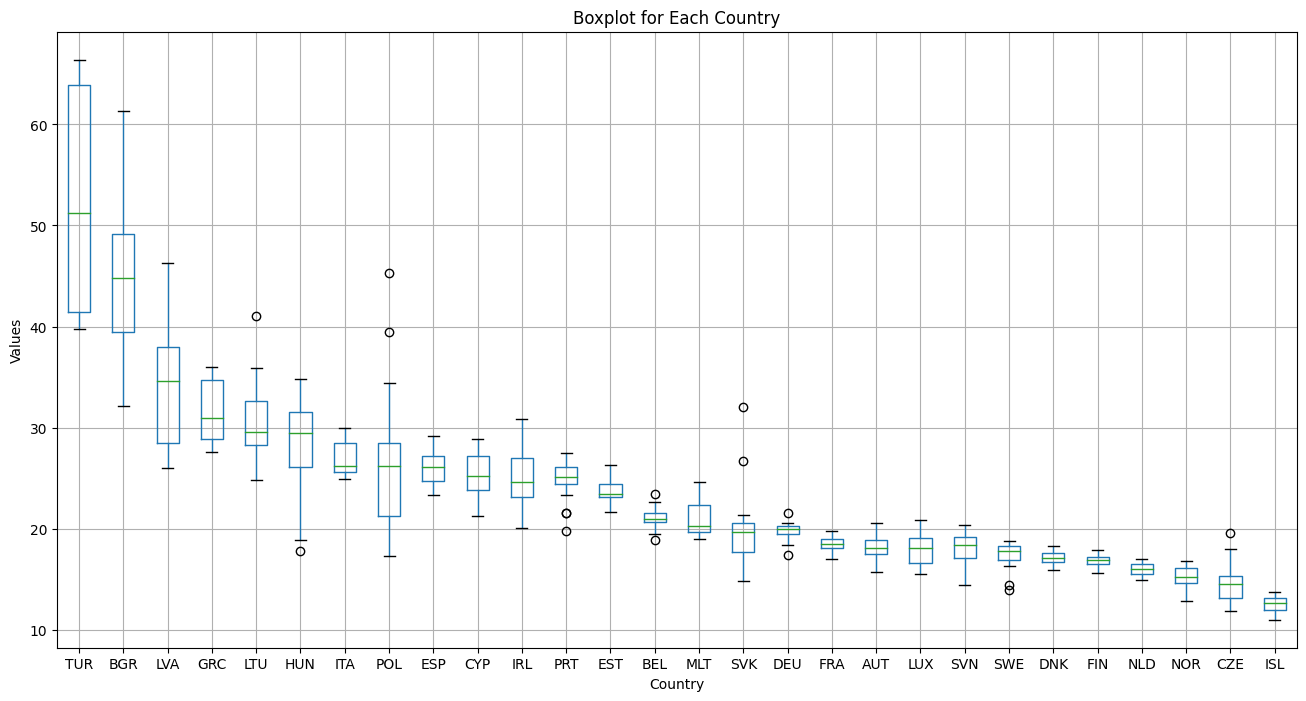

In [ ]:
risk_copy = risk_dropna.copy()
risk_copy.set_index('Abbreviation', inplace = True)
risk_copy.drop(columns = 'Country', inplace = True)
risk_transposed = risk_copy.T
plt.figure(figsize = (16, 8))
risk_transposed.boxplot()
plt.title('Boxplot for Each Country')
plt.xlabel('Country')
plt.ylabel('Values')
plt.show()

## Boxplot: one for each country on a total of 18 years (max 3 nulls)

We prepare the CSV file for the JavaScript.

In [ ]:
countries = []
abbreviations = []
values = []

for abbreviation in risk_transposed.columns:
    for year, value in risk_transposed[abbreviation].items():
        if not pd.isna(value):
            countries.append(country_abbreviations_reversed.get(abbreviation))
            abbreviations.append(abbreviation)
            values.append(value)

boxplot_dataframe = pd.DataFrame({'country': countries, 'abbreviation': abbreviations, 'value': values})
boxplot_dataframe.to_csv('boxplot.csv', index = False)

# Poverty: NEET vs Risk of Poverty (15-29) in 2009-2020

We import data about NEET percentage for each country.

In [ ]:
years = range(2009, 2023)
file_path = '/content/drive/MyDrive/DV_project/story1/NEET.xlsx'
sheet_names = 'Sheet 4'
rows_to_skip = list(range(0, 9)) + [10, 11, 12] + list(range(47, 53))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    neet_percentage = pd.read_excel(file_path, sheet_name = sheet_names, skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)

neet_percentage.rename(columns = {'TIME': 'Country'}, inplace = True)
neet_percentage['Abbreviation'] = neet_percentage['Country'].map(country_abbreviations)

In [ ]:
neet_years = {}
for year in years:
    neet_years[f'neet_{year}'] = neet_percentage[['Country', 'Abbreviation', str(year)]].copy()
    neet_years[f'neet_{year}'].dropna(subset = [str(year)], inplace = True)

We import data about RISK OF POVERTY percentage for each country.

In [ ]:
years = range(2009, 2021)
file_path = '/content/drive/MyDrive/DV_project/story2/poverty_exclusion_risk.xlsx'
sheet_names = 'Sheet 1'
rows_to_skip = list(range(0, 9)) + list(range(10, 19)) + [49, 52] + list(range(55, 63))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    poverty_percentage = pd.read_excel(file_path, sheet_name = sheet_names, skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)

poverty_percentage.rename(columns = {'TIME': 'Country'}, inplace = True)
poverty_percentage['Abbreviation'] = poverty_percentage['Country'].map(country_abbreviations)

In [ ]:
poverty_years = {}
for year in years:
    poverty_years[f'poverty_{year}'] = poverty_percentage[['Country', 'Abbreviation', str(year)]].copy()
    poverty_years[f'poverty_{year}'].dropna(subset = [str(year)], inplace = True)

## Scatterplots: NEET and Risk of Poverty for each country

In [ ]:
# We prepare the datasets for the scatterplots (one for year), merging values from the two datasets (NEETs and POVERTY)
merged_years = {}
for year in years:
    merged_years[f'merged_{year}'] = pd.merge(neet_years[f'neet_{year}'], poverty_years[f'poverty_{year}'], on = ['Country', 'Abbreviation'], how = 'left')
    merged_years[f'merged_{year}'].rename(columns = {f'{year}_x': 'neet', f'{year}_y': 'poverty'}, inplace = True)
    merged_years[f'merged_{year}'].to_csv(f'scatterplot{year}.csv', index = False)

# Poverty: risk by sex and age (0+), by education and labour status (18+) in 2009-2020

In [ ]:
poverty = {}
years = range(2009, 2021)

We import data about RISK OF POVERTY percentage by sex for each country.

In [ ]:
file_path = '/content/drive/MyDrive/DV_project/story2/risk_sex_age.xlsx'
sheet_names = ['Sheet 2', 'Sheet 3']
suffixes1 = ['Male', 'Female']
rows_to_skip = list(range(0, 9)) + [10, 11, 13] + list(range(15, 19)) + [49, 52] + list(range(55, 63))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    poverty['Sex'] = {f'{suffix}': pd.read_excel(file_path, sheet_name = sheet_names[i], skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)
                      for i, suffix in enumerate(suffixes1)}

for suffix in suffixes1:
    poverty['Sex'][f'{suffix}'].rename(columns = {'TIME': 'Country'}, inplace = True)
    poverty['Sex'][f'{suffix}'].at[0, '2009'] = poverty['Sex'][f'{suffix}'].at[1, '2009'].copy()
    poverty['Sex'][f'{suffix}']['Abbreviation'] = poverty['Sex'][f'{suffix}']['Country'].map(country_abbreviations)
    poverty['Sex'][f'{suffix}'].drop(1, inplace = True)
    poverty['Sex'][f'{suffix}'].reset_index(drop = True, inplace = True)

We import data about RISK OF POVERTY percentage by age range for each country.

In [ ]:
file_path = '/content/drive/MyDrive/DV_project/story2/risk_sex_age.xlsx'
sheet_names = ['Sheet 4', 'Sheet 7', 'Sheet 10', 'Sheet 13', 'Sheet 16']
suffixes2 = ['Less than 18', '18-24', '25-49', '50-64', '65 and over']
rows_to_skip = list(range(0, 9)) + [10, 11, 13] + list(range(15, 19)) + [49, 52] + list(range(55, 63))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    poverty['Age range'] = {f'{suffix}': pd.read_excel(file_path, sheet_name = sheet_names[i], skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)
                      for i, suffix in enumerate(suffixes2)}

for suffix in suffixes2:
    poverty['Age range'][f'{suffix}'].rename(columns = {'TIME': 'Country'}, inplace = True)
    poverty['Age range'][f'{suffix}'].at[0, '2009'] = poverty['Age range'][f'{suffix}'].at[1, '2009'].copy()
    poverty['Age range'][f'{suffix}']['Abbreviation'] = poverty['Age range'][f'{suffix}']['Country'].map(country_abbreviations)
    poverty['Age range'][f'{suffix}'].drop(1, inplace = True)
    poverty['Age range'][f'{suffix}'].reset_index(drop = True, inplace = True)

We import data about RISK OF POVERTY percentage by education level for each country.

In [ ]:
file_path = '/content/drive/MyDrive/DV_project/story2/risk_education.xlsx'
sheet_names = ['Sheet 1', 'Sheet 2', 'Sheet 3']
suffixes3 = ['Low', 'Medium', 'High']
rows_to_skip = list(range(0, 10)) + [11, 12, 14] + list(range(16, 19)) + [49, 52] + list(range(55, 65))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    poverty['Education'] = {f'{suffix}': pd.read_excel(file_path, sheet_name = sheet_names[i], skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)
                            for i, suffix in enumerate(suffixes3)}

for suffix in suffixes3:
    poverty['Education'][f'{suffix}'].rename(columns = {'TIME': 'Country'}, inplace = True)
    poverty['Education'][f'{suffix}'].at[0, '2009'] = poverty['Education'][f'{suffix}'].at[1, '2009'].copy()
    poverty['Education'][f'{suffix}']['Abbreviation'] = poverty['Education'][f'{suffix}']['Country'].map(country_abbreviations)
    poverty['Education'][f'{suffix}'].drop(1, inplace = True)
    poverty['Education'][f'{suffix}'].reset_index(drop = True, inplace = True)

We import data about RISK OF POVERTY percentage by activity status for each country.

In [ ]:
file_path = '/content/drive/MyDrive/DV_project/story2/risk_labour.xlsx'
sheet_names = ['Sheet 1', 'Sheet 2', 'Sheet 3', 'Sheet 4']
suffixes4 = ['Employed', 'Unemployed', 'Retired', 'Inactive']
rows_to_skip = list(range(0, 10)) + [11, 12, 14] + list(range(16, 19)) + [49, 52] + list(range(55, 63))
selected_columns = ['TIME'] + [str(year) for year in years]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")
    poverty['Activity status'] = {f'{suffix}': pd.read_excel(file_path, sheet_name = sheet_names[i], skiprows = rows_to_skip, na_values = ':', usecols = selected_columns)
                            for i, suffix in enumerate(suffixes4)}

for suffix in suffixes4:
    poverty['Activity status'][f'{suffix}'].rename(columns = {'TIME': 'Country'}, inplace = True)
    poverty['Activity status'][f'{suffix}'].at[0, '2009'] = poverty['Activity status'][f'{suffix}'].at[1, '2009'].copy()
    poverty['Activity status'][f'{suffix}']['Abbreviation'] = poverty['Activity status'][f'{suffix}']['Country'].map(country_abbreviations)
    poverty['Activity status'][f'{suffix}'].drop(1, inplace = True)
    poverty['Activity status'][f'{suffix}'].reset_index(drop = True, inplace = True)

## Barcharts: sex, age, education and labour

We export one CSV file for each country (excluded EU, which is the observation of index 0).

In [ ]:
country_barcharts = {}
countries_in_dataset_order = list(poverty['Sex']['Male']['Country'])[1:]
for idx, country in enumerate(countries_in_dataset_order, start = 1):
    rows = []
    for year in years:
        for indicator in list(poverty.keys()):
            for category in list(poverty[indicator].keys()):
                rows.append(pd.DataFrame([{'year': str(year), 'indicator': indicator, 'category': category, 'value': poverty[indicator][f'{category}'][str(year)][idx]}]))

    country_barcharts[f'{country_abbreviations.get(country)}'] = pd.concat(rows, ignore_index = True)
    country_barcharts[f'{country_abbreviations.get(country)}'].to_csv(f'barchart_{country_abbreviations.get(country)}.csv', index = False)

We export one CSV file for EU.

In [ ]:
rows = []
for year in years:
    for indicator in list(poverty.keys()):
        for category in list(poverty[indicator].keys()):
            rows.append(pd.DataFrame([{'year': str(year), 'indicator': indicator, 'category': category, 'value': poverty[indicator][f'{category}'][str(year)][0]}]))
poverty_EU = pd.concat(rows, ignore_index = True)
poverty_EU.to_csv('barchart_EU.csv', index = False)

# Download all CSV files

We download all the CSV files we created.

In [ ]:
directory_path = '/content'
file_type = ".csv"
files_to_download = glob.glob(f"{directory_path}/*{file_type}")
zip_filename = "barchart_per_country.zip"
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for file in files_to_download:
        zipf.write(file, arcname = os.path.basename(file))
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We remove all the CSV files we downloaded.

In [ ]:
for file in files_to_download:
    os.remove(file)

# EXTRA: Enrolment by age (15-29) in 2013-2021 --> we are NOT using this dataset for visualisations!

We read the CSV dataset.

In [ ]:
enrolment = pd.read_csv("/content/drive/MyDrive/DV_project/story2/enrolment_by_age.csv")

We observe the column values.

In [ ]:
distinct_values_dict = {col: enrolment[col].unique() for col in enrolment.columns}
for col, values in distinct_values_dict.items():
    print(f"\nDistinct values for column '{col}': {values}")


Distinct values for column 'COUNTRY': ['AUT' 'BEL' 'CZE' 'DNK' 'FIN' 'FRA' 'DEU' 'GRC' 'HUN' 'ISL' 'IRL' 'ITA'
 'LUX' 'NLD' 'NOR' 'POL' 'PRT' 'SVK' 'ESP' 'SWE' 'CHE' 'TUR' 'EST' 'LVA'
 'LTU' 'SVN' 'BGR' 'HRV' 'ROU']

Distinct values for column 'Country': ['Austria' 'Belgium' 'Czechia' 'Denmark' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Luxembourg' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'Slovak Republic' 'Spain' 'Sweden'
 'Switzerland' 'Türkiye' 'Estonia' 'Latvia' 'Lithuania' 'Slovenia'
 'Bulgaria' 'Croatia' 'Romania']

Distinct values for column 'SEX': ['F' 'M' '_T']

Distinct values for column 'Gender': ['Female' 'Male' 'Total']

Distinct values for column 'AGE': ['Y15' 'Y16' 'Y17' 'Y18' 'Y19' 'Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26'
 'Y27' 'Y28' 'Y29' '_T']

Distinct values for column 'Age': ['15 years' '16 years' '17 years' '18 years' '19 years' '20 years'
 '21 years' '22 years' '23 years' '24 years' '25 years' '26 years'
 '27 years' '28 ye

We discard missing values, 0s and uninteresting information (like the gender, because we are going to consider just the total value).

In [ ]:
filtered_enrolment = enrolment[~enrolment['Flag Codes'].isin(['m', 'o']) \
                               & (enrolment['Value'].notna()) \
                               & (enrolment['Value']!= 0) \
                               & (enrolment['INTENSITY'] == '_T') \
                               & (enrolment['SEX'] == '_T')
                               ]

We drop useless columns and we round the absolute value to an int (it could have been a float because it could derive from a mean over a wider range of ages).

In [ ]:
enrolment_final = filtered_enrolment.copy()
enrolment_final.drop(['SEX', 'Gender', 'AGE', 'INTENSITY', 'Intensity', 'YEAR', 'Flag Codes', 'Flags'], axis = 1, inplace = True)
enrolment_final['Value'] = enrolment_final['Value'].round(0).astype(int)
enrolment_final.rename(columns = {'COUNTRY': 'Abbreviation'}, inplace = True)
enrolment_final['Country'] = enrolment_final['Abbreviation'].map(country_abbreviations_reversed)

We again observe the column values left.

In [ ]:
filtered_distinct_values_dict = {col: enrolment_final[col].unique() for col in enrolment_final.columns}
for col, values in filtered_distinct_values_dict.items():
    print(f"\nDistinct values for column '{col}': {values}")


Distinct values for column 'Abbreviation': ['AUT' 'BEL' 'CZE' 'DNK' 'FIN' 'FRA' 'DEU' 'GRC' 'HUN' 'ISL' 'IRL' 'ITA'
 'LUX' 'NLD' 'NOR' 'POL' 'PRT' 'SVK' 'ESP' 'SWE' 'CHE' 'TUR' 'EST' 'LVA'
 'LTU' 'SVN' 'BGR' 'HRV' 'ROU']

Distinct values for column 'Country': ['Austria' 'Belgium' 'Czechia' 'Denmark' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Luxembourg' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'Slovakia' 'Spain' 'Sweden' 'Switzerland'
 'Türkiye' 'Estonia' 'Latvia' 'Lithuania' 'Slovenia' 'Bulgaria' 'Croatia'
 'Romania']

Distinct values for column 'Age': ['15 years' '16 years' '17 years' '18 years' '19 years' '20 years'
 '21 years' '22 years' '23 years' '24 years' '25 years' '26 years'
 '27 years' '28 years' '29 years' 'Total']

Distinct values for column 'EDUCATION_LEV': ['ISCED11_1' 'ISCED11_2' 'ISCED11_24' 'ISCED11_3' 'ISCED11_34'
 'ISCED11_35' 'ISCED11_5' 'ISCED11_55' 'ISCED11_7' 'ISCED11_5T8'
 'ISCED11_T' 'ISCED11_25' 'ISCED11_4' 'ISCED11_44' 

We create a dictionary linking each education level code to its description.

In [ ]:
education_level_dict = dict(zip(enrolment_final['EDUCATION_LEV'].unique(), enrolment_final['Education level'].unique()))
sorted_education_level_dict = dict(sorted(education_level_dict.items()))
print(sorted_education_level_dict)

{'ISCED11_0': 'Early childhood education', 'ISCED11_01': 'Early childhood educational development', 'ISCED11_02': 'Pre-primary education', 'ISCED11_1': 'Primary education', 'ISCED11_2': 'Lower secondary education', 'ISCED11_24': 'Lower secondary general education', 'ISCED11_25': 'Lower secondary vocational education', 'ISCED11_3': 'Upper secondary education', 'ISCED11_34': 'Upper secondary general education', 'ISCED11_35': 'Upper secondary vocational education', 'ISCED11_4': 'Post-secondary non-tertiary education', 'ISCED11_44': 'Post-secondary non-tertiary general education', 'ISCED11_45': 'Post-secondary non-tertiary vocational education', 'ISCED11_5': 'Short-cycle tertiary education', 'ISCED11_54': 'Short-cycle tertiary general education', 'ISCED11_55': 'Short-cycle tertiary vocational education', 'ISCED11_5T8': 'Tertiary education', 'ISCED11_6': 'Bachelor’s or equivalent level', 'ISCED11_7': 'Master’s or equivalent level', 'ISCED11_8': 'Doctoral or equivalent level', 'ISCED11_T': '

We retrieve the information for each country and for each year between 2013 and 2021.

In [ ]:
years = range(2013, 2022)
enrolment_country = {}

for country in enrolment_final['Country'].unique():
    enrolment_country[country] = {}

    for year in years:
        current_data = enrolment_final[(enrolment_final['Country'] == country) & (enrolment_final['Year'] == year)].copy()
        enrolment_country[country][f'enrolment{year}_unfiltered'] = current_data.copy()
        current_data = current_data[current_data['Age'] != 'Total']
        enrolment_country[country][f'enrolment{year}'] = current_data.copy()

### Streamgraphs --> we do not use this type of visualization

We modify the structure of the data we have, to obtain for each country and for each year a dataframe with 15 rows (one for each age between 15 and 29) and columns for each education level (with its absolute value).

In [ ]:
education_levels = list(sorted_education_level_dict.values())
streamgraph_dataframes = {}

for year in years:
    for country in enrolment_final['Country'].unique():

        df = enrolment_country[country][f'enrolment{year}'].copy()
        pivoted_df = df.pivot_table(index = 'Age', columns = 'Education level', values = 'Value', fill_value = 0) ### We pivot the dataset
        pivoted_df = pivoted_df.reindex(columns = education_levels, fill_value = 0) ### We reindex to include all education levels, fill missing values with 0
        pivoted_df = pivoted_df.reset_index() ### We reset the index to make 'Age' a regular column
        streamgraph_dataframes[f'enrolment_{country_abbreviations.get(country)}_{year}'] = pivoted_df.copy() ### We store the pivoted DataFrame in the dictionary

We sum values for all the countries, and then we average the value over the 9 years.

In [ ]:
for year in years:
    keys_with_same_year = [key for key in streamgraph_dataframes.keys() if key.endswith(str(year))]
    concatenated_dataframe = pd.concat([streamgraph_dataframes[key] for key in keys_with_same_year])
    sum_dataframe = concatenated_dataframe.groupby('Age').sum(numeric_only = True)
    sum_dataframe = sum_dataframe.reset_index() ### We reset the index to make 'Age' a regular column
    streamgraph_dataframes[f'enrolment_{year}_all'] = sum_dataframe.copy()

keys_with_all = [key for key in streamgraph_dataframes.keys() if key.endswith('all')]
concatenated_dataframe = pd.concat([streamgraph_dataframes[key] for key in keys_with_all])
streamgraph_dataframes['enrolment_all'] = concatenated_dataframe.groupby('Age').mean().round(0).astype(int)
streamgraph_dataframes['enrolment_all'] = streamgraph_dataframes['enrolment_all'].reset_index()

We show the final dataset,  summed over countries and averaged over years.

In [ ]:
streamgraph_dataframes['enrolment_all']

Education level,Age,Early childhood education,Early childhood educational development,Pre-primary education,Primary education,Lower secondary education,Lower secondary general education,Lower secondary vocational education,Upper secondary education,Upper secondary general education,...,Post-secondary non-tertiary general education,Post-secondary non-tertiary vocational education,Short-cycle tertiary education,Short-cycle tertiary general education,Short-cycle tertiary vocational education,Tertiary education,Bachelor’s or equivalent level,Master’s or equivalent level,Doctoral or equivalent level,Total
0,15 years,1369,0,1369,17863,2051469,2023774,27695,3701373,2293020,...,21,1084,45,0,45,261,195,20,0,5773441
1,16 years,1130,0,1130,13521,709582,644002,65581,4892472,2893315,...,258,12553,421,0,334,2182,1685,76,0,5631699
2,17 years,843,0,843,13382,251647,177988,73928,5052201,2890262,...,821,34014,22152,0,21899,78569,49648,6769,0,5431476
3,18 years,668,0,668,8208,122733,80503,42596,3247631,1587018,...,3196,87306,263421,6,262301,1119200,761111,94658,10,4588940
4,19 years,495,0,495,7327,60259,39875,20797,1398748,469303,...,7192,181031,442686,233,440637,2170450,1535742,192011,11,3770496
5,20 years,240,0,240,8201,43094,30391,12935,694334,207352,...,10450,198650,416280,403,414297,2611262,1925619,269340,22,3566230
6,21 years,102,0,102,7723,30714,22556,8661,448951,131761,...,11120,167038,333958,403,332494,2640181,1924707,381409,107,3305827
7,22 years,49,0,49,7453,25014,19881,5619,318714,104934,...,10088,125462,264269,381,262643,2446117,1597285,583583,980,2932899
8,23 years,24,0,24,7759,21800,18312,4007,245358,87295,...,8408,93977,216338,359,215300,2127086,1174906,728551,7291,2504415
9,24 years,11,0,11,8312,19319,16833,3007,201462,75090,...,6923,83590,183557,332,182537,1740036,875484,657424,23570,2021761


We drop unrelevant columns and we export it for a possible visualization.

In [ ]:
streamgraph_final = streamgraph_dataframes['enrolment_all'].copy()
streamgraph_final.drop(['Early childhood educational development',
                        'Pre-primary education',
                        'Lower secondary general education',
                        'Lower secondary vocational education',
                        'Upper secondary general education',
                        'Upper secondary vocational education',
                        'Post-secondary non-tertiary general education',
                        'Post-secondary non-tertiary vocational education',
                        'Short-cycle tertiary general education',
                        'Short-cycle tertiary vocational education',
                        'Total'], axis = 1, inplace = True)

In [ ]:
streamgraph_final.to_csv('streamgraph_final.csv', index = False)

### Grouped barcharts --> we do not use this type of visualization

In [ ]:
grouped_barchart = streamgraph_dataframes['enrolment_all'].copy()

We group for low, medium and high level of education.

In [ ]:
grouped_barchart['low'] = grouped_barchart['Early childhood education'] + grouped_barchart['Primary education'] + grouped_barchart['Lower secondary education']
grouped_barchart['medium'] = grouped_barchart['Upper secondary education'] + grouped_barchart['Post-secondary non-tertiary education']
grouped_barchart['high'] = grouped_barchart['Tertiary education']

We bin the ages in five different 3-years ranges.

In [ ]:
bins = [15, 18, 21, 24, 27, 30]
labels = ['15-17 years', '18-20 years', '21-23 years', '24-26 years', '27-29 years']
grouped_barchart['Age'] = grouped_barchart['Age'].str.extract('(\d+)').astype(float).astype(int)
grouped_barchart['age'] = pd.cut(grouped_barchart['Age'], bins = bins, labels = labels, right = False)

#### Low, medium, high

In [ ]:
grouped_barchart_levels = grouped_barchart.groupby('age').agg({'low': 'sum', 'medium': 'sum', 'high': 'sum'}).reset_index()
grouped_barchart_levels.to_csv('grouped_barchart_levels.csv', index = False)

In [ ]:
grouped_barchart_levels.iloc[:, 1:4] = grouped_barchart_levels.iloc[:, 1:4].div(1000).round(1)
grouped_barchart_levels.to_csv('grouped_barchart_levelsK.csv', index = False)

#### 5 groups: primary, lower secondary, upper secondary, post-secondary, tertiary

In [ ]:
grouped_barchart5 = grouped_barchart.groupby('age').agg({'Primary education': 'sum',
                                                         'Lower secondary education': 'sum',
                                                         'Upper secondary education': 'sum',
                                                         'Post-secondary non-tertiary education': 'sum',
                                                         'Tertiary education': 'sum'}).reset_index()
grouped_barchart5.to_csv('grouped_barchart.csv', index = False)

In [ ]:
grouped_barchart5.iloc[:, 1:6] = grouped_barchart5.iloc[:, 1:6].div(1000).round(1)
grouped_barchart5.to_csv('grouped_barchartK.csv', index = False)

#### 3 + tooltip

In [ ]:
grouped_barchart_all_levels = grouped_barchart.groupby('age').agg({'low': 'sum',
                                                            'medium': 'sum',
                                                            'high': 'sum',

                                                            'Early childhood education': 'sum',
                                                            'Primary education': 'sum',
                                                            'Lower secondary education': 'sum',

                                                            'Upper secondary education': 'sum',
                                                            'Post-secondary non-tertiary education': 'sum',

                                                            'Short-cycle tertiary education': 'sum',
                                                            'Bachelor’s or equivalent level': 'sum',
                                                            'Master’s or equivalent level': 'sum',
                                                            'Doctoral or equivalent level': 'sum'}).reset_index()
grouped_barchart_all_levels.to_csv('grouped_barchart_all_levels.csv', index = False)

In [ ]:
grouped_barchart_all_levels.iloc[:, 1:6] = grouped_barchart_all_levels.iloc[:, 1:6].div(1000).round(1)
grouped_barchart_all_levels.to_csv('grouped_barchart_all_levelsK.csv', index = False)

#### 5 + tooltip

In [ ]:
grouped_barchart_all = grouped_barchart.groupby('age').agg({'Primary education': 'sum',
                                                             'Lower secondary education': 'sum',
                                                             'Upper secondary education': 'sum',
                                                             'Post-secondary non-tertiary education': 'sum',
                                                             'Tertiary education': 'sum',

                                                             'Lower secondary general education': 'sum',
                                                             'Lower secondary vocational education': 'sum',

                                                             'Upper secondary general education': 'sum',
                                                             'Upper secondary vocational education': 'sum',

                                                             'Post-secondary non-tertiary general education': 'sum',
                                                             'Post-secondary non-tertiary vocational education': 'sum',

                                                             'Short-cycle tertiary education': 'sum',
                                                             'Bachelor’s or equivalent level': 'sum',
                                                             'Master’s or equivalent level': 'sum',
                                                             'Doctoral or equivalent level': 'sum'}).reset_index()
grouped_barchart_all.to_csv('grouped_barchart_all.csv', index = False)

In [ ]:
grouped_barchart_all.iloc[:, 1:6] = grouped_barchart_all.iloc[:, 1:6].div(1000).round(1)
grouped_barchart_all.to_csv('grouped_barchart_allK.csv', index = False)